In [1]:
!pip install numpy
!pip install matplotlib
!pip install qulacs

You should consider upgrading via the 'c:\users\koich\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\koich\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\koich\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from qulacs import QuantumState, QuantumCircuit, Observable
from qulacs.gate import Z, RY, merge, DenseMatrix, Identity
from Adder import add_adder_gate
from Subtracter import add_subtracter_gate
from ConstSetter import add_const_setter_gate, add_ctrl_const_setter_gate

# QAE を用いたデジタルオプションプライシング

In [3]:
np.random.seed(1) #乱数のseedを設定

In [4]:
# 時点数
numTimeStep = 2

# 各時点での原資産価格の上昇・下落確率を表すqubitのインデックス
pIds = [0, 1]

# 上昇確率
pUps = [0.4, 0.4]

# 上昇・下落幅
deltaUdl = 1

# デジタルオプションの閾値
th = 4

# 原資産価格初期値
udlIni = 2

In [5]:
# 計算に要する桁数
digit = 3

# 原資産価格を保持するレジスタのqubitのインデックス
# digitに加え一桁余分に確保しておく（last qubitがQAEのターゲットになる）
udlResIdStart = pIds[-1] + 1
udlResIdEnd = udlResIdStart + digit
udlResIds = list(range(udlResIdStart, udlResIdEnd + 1))
qaeTargetId = udlResIdEnd

# 原資産価格レジスタに加える値を一時的に保持するレジスタ
tempResIdStart = udlResIdEnd + 1
tempResIdEnd = tempResIdStart + digit - 1
tempResIds = list(range(tempResIdStart, tempResIdEnd + 1))

# 繰り上がり用レジスタ
carryResIdStart = tempResIdEnd + 1
carryResIdEnd = carryResIdStart + digit - 1
carryResIds = list(range(carryResIdStart, carryResIdEnd + 1))

# 総qubit数
totQubitNum = carryResIdEnd + 1

# 全qubit index
idsAll = list(range(totQubitNum))

In [6]:
### 原資産価格を計算し、閾値以上か否かを判定する回路を、QuantumCircuit gとして構成していく
g = QuantumCircuit(totQubitNum)

### 原資産価格初期値をセット
add_const_setter_gate(g, udlIni, udlResIds)

### 上昇・下落確率を指定のqubitの|1>のamplitudeとして埋め込み
for i in range(numTimeStep):
    pGate_i = 問１# 注：時点t=1,2での上昇・下落確率を示す量子ビットのインデックスはpIds[0],pIds[1]
    g.add_gate(pGate_i)

### 原資産価格の増減をtemporary registerにセットし、原資産価格レジスタに足す
for i in range(numTimeStep):
    # 上昇の場合
    add_ctrl_const_setter_gate(g, deltaUdl, pIds[i], tempResIds, True) # 上昇額をtemporary registerにセット
    add_adder_gate(g, tempResIds, udlResIds, carryResIds) # 原資産価格レジスタに加える
    add_ctrl_const_setter_gate(g, deltaUdl, pIds[i], tempResIds, True) # temporary registerをリセット
    
    # 下落の場合
    add_ctrl_const_setter_gate(g, deltaUdl, pIds[i], tempResIds, False) # 下落額temporary registerにセット
    add_subtracter_gate(g, tempResIds, udlResIds, carryResIds) # 原資産価格レジスタから減ずる
    add_ctrl_const_setter_gate(g, deltaUdl, pIds[i], tempResIds, False) # temporary registerをリセット
    
### 原資産価格が閾値以上となっているか否かのチェック
# 閾値の2の補数（原資産価格レジスタにこれを足して最上位ビットが1となる⇔原資産価格が閾値以上）
twosComplTh = (th^(2 ** digit - 1)) + 1
add_const_setter_gate(g, twosComplTh, tempResIds) # temporary registerに閾値の2の補数をセット
add_adder_gate(g, tempResIds, udlResIds, carryResIds) # 閾値の2の補数を原資産価格レジスタに足す

In [7]:
### gの逆回路
gInv = g.get_inverse()

In [8]:
### QAEに必要なゲート
# QAE target qubitが|1>なら-1倍するゲート
# 即ち、当該qubitに対するZ gate
targetStateFlip = 問２ # 注：target qubitのインデックスはqaeTargetId

# |0...0>を-1倍するゲート
# DenseMatrixで生成
flipIfAll0 = DenseMatrix(idsAll, np.diag([-1 if i == 0 else 1 for i in range(2 ** totQubitNum)]))

# Grover operator
grover = QuantumCircuit(totQubitNum)
grover.add_gate(targetStateFlip)
grover.merge_circuit(gInv)
grover.add_gate(flipIfAll0)
grover.merge_circuit(g)

In [9]:
### QAEの設定
mMax = 4 # Grover operatorを2^mMax回まで作用
groverNums = np.array([0] + [2 ** i for i in range(mMax + 1)]) # Grover operatorの作用回数(0, 2^1, 2^2,...)
nShot = 1000 # 1つの作用回数のパターンに対する観測回数

# 尤度関数の最大点候補（[0, 0.5]を100000等分して網羅探索）
numPoints = 100000
thetas = 0.5 / numPoints * np.array(range(numPoints + 1))

In [10]:
### QAE
# オブサーバブルzTgtの定義（QAE target qubitのZ）
obs = Observable(totQubitNum)
obs.add_operator(1, 'Z ' + str(qaeTargetId))

# 状態の生成・初期化
state = QuantumState(totQubitNum)
state.set_zero_state()

# gを一回作用させた状態|Ψ>
# これのtarget qubitを測定して1を得る確率 ＝ 求めたい確率（「原資産価格≧閾値」となる確率）
g.update_quantum_state(state)

# Groverの作用回数を色々と変えたとき、それぞれの下で「1を得る回数」のサンプル値を格納するリスト
n1s = []

for i in range(len(groverNums)):
    groverNumAdd = groverNums[0] if i == 0 else groverNums[i] - groverNums[i - 1] # 追加の作用回数
    for j in range(groverNumAdd): grover.update_quantum_state(state) # その回数だけGrover operatorを作用
    prob1 = 0.5 * (1.0 - obs.get_expectation_value(state)) # target qubitに1を得る確率
    n1 = np.random.binomial(nShot, prob1) # 1を得る回数のサンプル値
    n1s.append(n1)

In [11]:
### 対数尤度関数の定義
def liklihood(theta, i): # i: Groverの作用回数m0,m1,...,miに対する試行を勘案
    
    ret = 0.0
    
    for j in range(i + 1):
        pSq = np.sin((2.0 * groverNums[j] + 1) * np.pi * theta)
        p = pSq * pSq
        ret += n1s[j] * np.log(p) + (nShot - n1s[j]) * np.log(1.0 - p)
        
    return ret

In [12]:
### 各試行における最尤点
thetaMaxLiks = np.array([thetas[np.argmax([liklihood(th, i) for th in thetas])] for i in range(len(groverNums))])

### 各試行における求めたい確率の推定値
estimates = np.power(np.sin(thetaMaxLiks * np.pi), 2)

<ipython-input-11-964349f68839>:9: RuntimeWarning: divide by zero encountered in log
  ret += n1s[j] * np.log(p) + (nShot - n1s[j]) * np.log(1.0 - p)


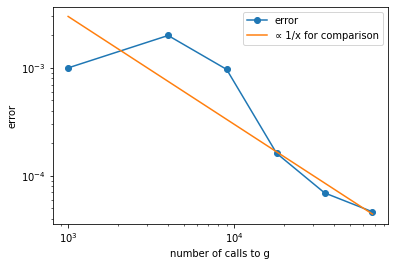

In [13]:
### Groverの作用回数と誤差のグラフ
pTrue = 0.16 # 求めたい確率の真の値
errs = np.abs(np.array(estimates) - pTrue) # 推定値との真の値の乖離
gCallNums = list(it.accumulate((2 * groverNums + 1) * nShot)) # 回路gおよびその逆を呼んだ回数
plt.xlabel('number of calls to g')
plt.ylabel('error')

# 描画
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.plot(gCallNums, errs, label="error", marker="o")

# 比較のためにy=1/xを書く
plt.plot(gCallNums, 3.0 / np.array(gCallNums), label="∝ 1/x for comparison")

ax.legend()
plt.show()